In [1]:
import tensorflow as tf
tf.__version__

'2.6.2'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization
from  tensorflow.keras.preprocessing.image  import  ImageDataGenerator

## 解压缩数据集

In [22]:
import zipfile
# 指定你的 zip 文件路径
zip_path = "dataset.zip"

# 指定你想要解压到的位置
extract_path = "dataset"

# 打开并解压 zip 文件
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
data_dir = 'self-drving-rccar-dataset'
batch_size = 32
img_height = 224
img_width = 224
BATCH_SIZE = batch_size
IMAGE_SIZE = (img_height,img_width)

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 2016 files belonging to 3 classes.
Using 1815 files for training.
Found 2016 files belonging to 3 classes.
Using 201 files for validation.
['go', 'left', 'right']


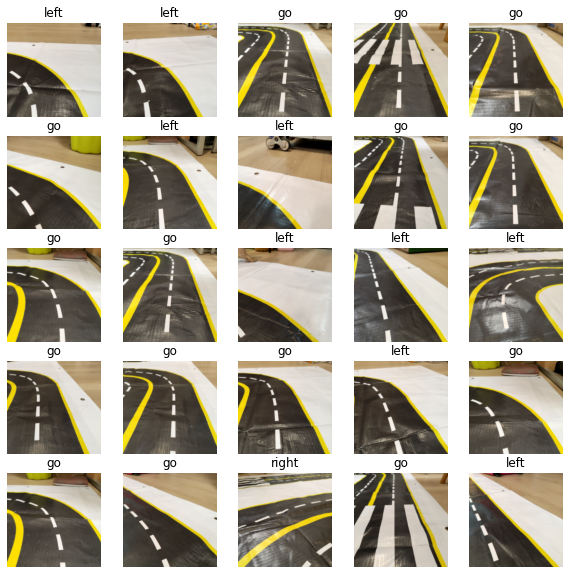

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# https://tf.wiki/zh_hans/basic/tools.html
# tf.data 的数据集对象为我们提供了 Dataset.prefetch() 方法，使得我们可以让数据集对象 Dataset 在训练时预取出若干个元素，使得在 GPU 训练的同时 CPU 可以准备数据，从而提升训练流程的效率。
print(AUTOTUNE)
# 此处参数 buffer_size 既可手工设置，也可设置为 tf.data.experimental.AUTOTUNE 从而由 TensorFlow 自动选择合适的数值。
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

-1


In [8]:
# num_classes = 3

model = Sequential()
model.add(BatchNormalization(input_shape=(img_height, img_width, 3)))
model.add(Conv2D(24, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(36, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2)))

# model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 3), activation='elu'))
# model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Dropout(0.5))
# model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(125, activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(60, activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(25, activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(3))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

epochs=8
history3 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

model.save('rccar.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 110, 110, 24)      1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 48)        43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 64)        27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 64)        0

### 保存模型

In [10]:
model.save('rccar.h5')

### 测试模型识别效果

In [11]:
img_height = 224
img_width = 224

sunflower_path = 'testset/go0203.png'
img = keras.preprocessing.image.load_img(
 sunflower_path, target_size=(img_height, img_width) )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
print(predictions)
print(class_names)
score = tf.nn.softmax(predictions[0])
print(
 "这张测试图片最有可能属于 {} 分类，置信度： {:.2f} ."
 .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print(score)

[[ 5.221459   7.6398687 -5.844331 ]]
['go', 'left', 'right']
这张测试图片最有可能属于 left 分类，置信度： 91.82 .
tf.Tensor([8.1779473e-02 9.1821915e-01 1.2788892e-06], shape=(3,), dtype=float32)


In [12]:
!tensorflowjs_converter --input_format=keras rccar.h5 rccar_tfjs_model

2024-05-24 21:22:33.083921: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2024-05-24 21:22:33.083945: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
import shutil

# 定义你想要压缩的文件夹的路径
directory_to_zip = "rccar_tfjs_model"

# 定义你希望创建的 zip 文件的名称（不需要添加.zip，这将被自动添加）
output_filename = "rccar_tfjs_model"

# 使用shutil来创建zip文件 
shutil.make_archive(output_filename, 'zip', directory_to_zip)

'E:\\cnnCar\\rccar_tfjs_model.zip'